In [1]:
import os, io
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import ruptures as rpt

pd.set_option("display.precision", 2)
from matplotlib.ticker import FormatStrFormatter

In [2]:
def read_data(path):
    if os.path.exists(path):
        df = pd.ExcelFile(path) # read feces file
        sheet_name = df.sheet_names[0] # use the first sheet in the .xlsx file
        df = df.parse(sheet_name, skiprows=0, parse_dates=[['date', 'time']]) 
    else:
        path = path.replace('xlsx', 'csv')
        df = pd.read_csv(path, parse_dates=[['date', 'time']])
    
    df.columns = df.columns.str.replace(' ', '')
    df = df.groupby('date_time', as_index=True).mean() # Combine reduplicative data
    df = df.interpolate(method='pad', limit_direction='forward', axis=0)
    df = df.resample('1S').pad()
    df = df.rolling(window=10).mean()
    return df

In [3]:
def plot_two_tank(df, titles=[], start_all = [], end_all=[]):
    # create figure and axis objects with subplots()
    myFmt = mdates.DateFormatter('%H:%M')
    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize=(20, 10))
    ax2=ax.twinx()
    # make a plot
#     ax.plot(df.loc[:, 'date_time'], df.loc[:, 'feces'], color="red", marker="o")
    ax.plot(df.index, df.loc[:, 'feces'], color="red", marker="o")
    # set y-axis label
    ax.set_ylabel("Feces Tank Volume (L)",color="red",fontsize=30)
    # twin object for two different y-axis on the sample plot
    
    # make a plot with different y-axis using second axis object
#     ax2.plot(df.loc[:, 'date_time'], df.loc[:, 'urine'], color="blue",marker="o")
    ax2.plot(df.index, df.loc[:, 'urine'], color="blue",marker="o")
#     ax.set_xlabel('Time (hh:mm)',fontsize=30)
    ax.set_xlabel('Seconds',fontsize=30)
#     ax.xaxis.set_major_formatter(myFmt)  
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax2.set_ylabel("Urine Tank Volume (L)",color="blue",fontsize=30)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    for i, (s, e) in enumerate(zip(start_all, end_all)):
        x_s, x_e =s, e
#         x_s = df.loc[s, 'date_time']
#         x_e = df.loc[e, 'date_time']
        plt.axvline(x=x_s, ls='--', linewidth=1, color = 'purple', label='start')
        plt.axvline(x=x_e, linewidth=1, color = 'black', label='end')
        if i == 0:
            plt.legend(fontsize = 30)
    
    plt.title('_'.join(titles))
    plt.show()
    
    return fig, ax, ax2

In [4]:
def detect_event(df, path_date, threshold = 0.001, th_end = 5):
    start_all = []
    end_all = []
    origin = 0
    start = df.index[0]
    end = start + 1
    i = 1
    
    while end < df.index[-1]:
#         print(origin, start, max(origin, start-30))
#         print(max(origin, start-30), start)
#         start_con_1 = (df.loc[max(origin, start-30): start, 'feces_derivative'] <= threshold).all()
#         start_con_2 = (df.loc[max(origin, start-30): start, 'urine_derivative'] <= threshold).all()
#         start_con_1 = len(df.loc[max(0, start-30): start, 'feces'].unique()) == 1 # change in FT == 0 for 30 seconds
#         start_con_2 = len(df.loc[max(0, start-30): start, 'urine'].unique()) == 1 # change in UT == 0 for 30 seconds
        start_con_3 = df.loc[start+1, 'feces'] - df.loc[start, 'feces'] != 0 # change in FT != 0
        start_con_4 = df.loc[start+1, 'urine'] - df.loc[start, 'urine'] != 0 # change in UT != 0
        
#         start_con_3 = (df.loc[start+1:start+5, 'feces_derivative'] > threshold).all()
#         start_con_4 = (df.loc[start+1:start+5, 'urine_derivative'] > threshold).all()

        end_con_1 = (df.loc[end+1:end+th_end, 'feces_derivative'] > threshold).any()
        end_con_2 = (df.loc[end+1:end+th_end, 'urine_derivative'] > threshold).any()
#         end_con_1 = df.loc[end, 'feces_derivative'] > threshold
#         end_con_2 = df.loc[end, 'urine_derivative'] > threshold
        
#         if (start_con_1 and start_con_2) and (start_con_3 or start_con_4):
        if start_con_3 or start_con_4:
            while (end_con_1 or end_con_2) and end < df.index[-1]:
                end += 1
#                 end_con_1 = df.loc[end, 'feces_derivative'] > threshold
#                 end_con_2 = df.loc[end, 'urine_derivative'] > threshold
                
                end_con_1 = (df.loc[end+1:end+th_end, 'feces_derivative'] > threshold).any()
                end_con_2 = (df.loc[end+1:end+th_end, 'urine_derivative'] > threshold).any()
#             if end - start > 10 or (df.loc[end, 'feces'] -df.loc[start, 'feces']>1) or (df.loc[end, 'urine'] -df.loc[start, 'urine']>0.1):
            if end - start > 10 and ((df.loc[end, 'feces'] -df.loc[start, 'feces']>1) or (df.loc[end, 'urine'] -df.loc[start, 'urine']>0.1)):
#             if end - start > 10:
#                 fig, ax, ax2 = plot_two_tank(df.loc[start-10:end+10, :], [], [start], [end])
#                 fig.savefig(os.path.join(path_date, 'event_' + str(i) + '.png'))
                i += 1
                start_all.append(start)
                end_all.append(end)
            start = end+1
            origin = start
            end = start + 1
        else:
            start += 1
            end = start + 1
#     for i in range(len(start_all))
            
    fig, ax, ax2 = plot_two_tank(df, [], start_all, end_all)
    return start_all, end_all

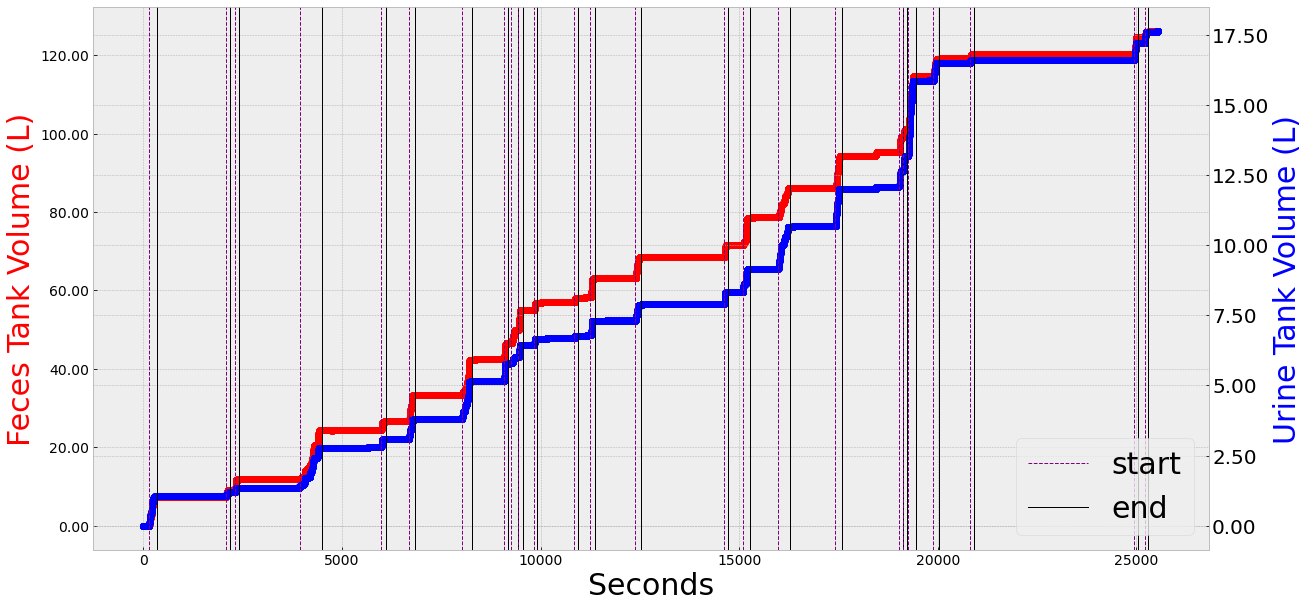

20200824
25


In [5]:
duration = []
f_change = []
u_change = []
f_max_derivative = []
u_max_derivative = []

num_events = []
# for date in ['20200824', '20200826', '20200828', '20200831', '20200901', 
#              '20200903', '20200907', '20200917', '20200921', 
#              '20200923', '20200925', '20200928', '20200930']:
for date in ['20200824']:
    path_date = os.path.join('data', date)
    path_feces = os.path.join(path_date, 'feces.xlsx')
    path_urine = os.path.join(path_date, 'urine.xlsx')

    df_feces = read_data(path_feces) # read feces file
    df_feces.columns = ['feces']
    df_urine = read_data(path_urine) # read feces file
    df_urine.columns = ['urine']
    df = pd.concat([df_feces, df_urine], axis=1)
    df = df.reset_index()
    df ['feces_derivative'] = df['feces'].diff(periods=10) / df['date_time'].diff(periods=10).dt.total_seconds()
    df ['urine_derivative'] = df['urine'].diff(periods=10) / df['date_time'].diff(periods=10).dt.total_seconds()
    df = df.dropna().reset_index(drop=True)
#     fig, ax, ax2 = plot_two_tank(df, ['all day'])
    start_all, end_all = detect_event(df.loc[:], path_date)
    
    for s, e in zip(start_all, end_all):
        duration.append(e-s)
        f_change.append(df.loc[e, 'feces']-df.loc[s, 'feces'])
        u_change.append(df.loc[e, 'urine']-df.loc[s, 'urine'])
        f_max_derivative.append(df.loc[s:e, 'feces_derivative'].max())
        u_max_derivative.append(df.loc[s:e, 'urine_derivative'].max())
    print(date)
    print(len(start_all))
    num_events.append(len(start_all))

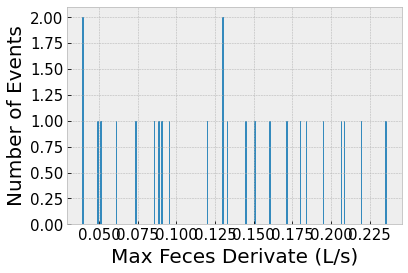

In [8]:
plt.hist(f_max_derivative, bins = 200)
plt.xlabel('Max Feces Derivate (L/s)', fontsize=20)
plt.ylabel('Number of Events', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

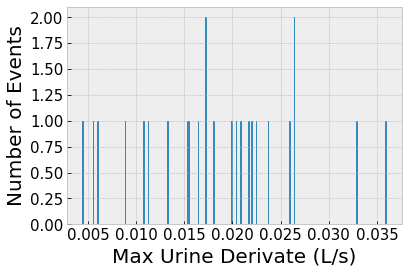

In [9]:
plt.hist(u_max_derivative, bins = 200)
plt.xlabel('Max Urine Derivate (L/s)', fontsize=20)
plt.ylabel('Number of Events', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

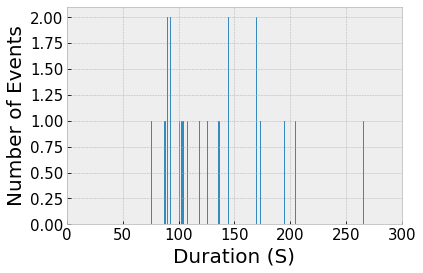

In [10]:
plt.hist(duration, bins = 500)
plt.xlabel('Duration (S)', fontsize=20)
plt.ylabel('Number of Events', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim((0,25))
plt.xlim((0,300))
plt.show()

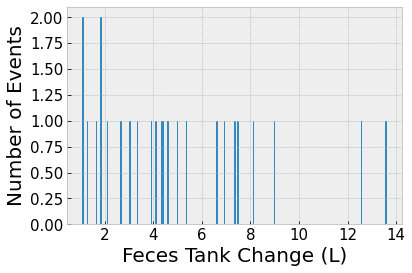

In [11]:
plt.hist(f_change, bins = 200)
plt.xlabel('Feces Tank Change (L)', fontsize=20)
plt.ylabel('Number of Events', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

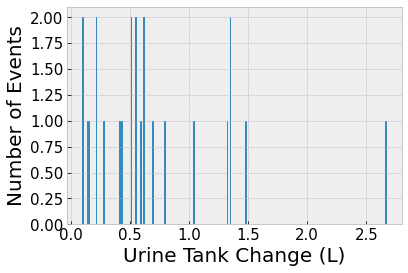

In [12]:
plt.hist(u_change, bins = 200)
plt.xlabel('Urine Tank Change (L)', fontsize=20)
plt.ylabel('Number of Events', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()